In [1]:
# import necessary libraries for this explorarion process
import os
import pandas as pd
import numpy as np
import dask
import dask_image.imread
import dask.array as da
import dask.dataframe as dd
import cv2
import napari
import matplotlib.pyplot as plt
import seaborn as sns
from distributed import Client, LocalCluster
import math

In [43]:
metadata_train_ori = pd.read_csv("plant-pathology-2021-fgvc8\\train.csv")
metadata_test_ori = pd.read_csv("plant-pathology-2021-fgvc8\\sample_submission.csv")
metadata_train = metadata_train_ori.copy()
metadata_test = metadata_test_ori.copy()
# split labels as every images will have more than 1 deseases
# metadata_train['labels'] = metadata_train['labels'].apply(lambda x: x.split())
display(metadata_train.labels.unique())
display(metadata_train.head())
# the data itself has 18632 row and 2 Columns
# which can be summarized that there is a 18632 images to loaded for training
display(metadata_train.info())

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


None

Because this is a multi-label image classification problem we need to separate each label, because we want our model to predict every deseases based on probabilty of each label.

In [42]:
labels = ['healthy', 'scab', 'frog_eye_leaf_spot' ,'complex', 'rust', 'powdery_mildew']
labels.sort()

In [44]:
train_img_path = "plant-pathology-2021-fgvc8/train_images"
metadata_train['labels'] = metadata_train['labels'].apply(lambda x: x.split())
metadata_test['labels'] = metadata_test['labels'].apply(lambda x: x.split())

# metadata_train['image'] = metadata_train['image'].apply(lambda x: train_img_path+"\\"+x) 

In [5]:
metadata_train 

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Save to .csv for ease of access

In [6]:
# df = pd.DataFrame(img_label_dict)
# df.to_csv('multi_label_train.csv', index=False)

In [7]:
df_ori = pd.read_csv('multi_label_train.csv')
df = df_ori.copy()

In [8]:
train_path = "train_images"
test_path = "test_images"
df['image'] = df['image'].apply(lambda x: train_path+"/"+x) 

In [9]:
df

,image,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,train_images/800113bb65efe69e.jpg,1.0,0.0,0.0,0.0,0.0,0.0
1,train_images/8002cb321f8bfcdf.jpg,0.0,1.0,1.0,1.0,0.0,0.0
2,train_images/80070f7fb5e2ccaa.jpg,0.0,1.0,0.0,0.0,0.0,0.0
3,train_images/80077517781fb94f.jpg,0.0,1.0,0.0,0.0,0.0,0.0
4,train_images/800cbf0ff87721f8.jpg,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
18627,train_images/fffb900a92289a33.jpg,1.0,0.0,0.0,0.0,0.0,0.0
18628,train_images/fffc488fa4c0e80c.jpg,0.0,1.0,0.0,0.0,0.0,0.0
18629,train_images/fffc94e092a59086.jpg,0.0,0.0,0.0,0.0,1.0,0.0
18630,train_images/fffe105cf6808292.jpg,0.0,1.0,1.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Labels for leaf deseases')

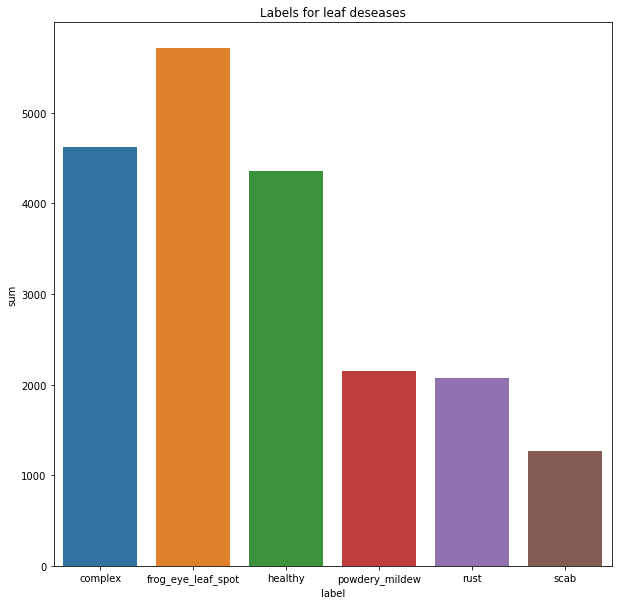

In [11]:
#check for unique variable
# unique_train = metadata_train.nunique()
# display(f"There are {unique_train.image} {metadata_train.columns[0]}(s) and {unique_train.labels} {metadata_train.columns[1]}.")
# unique_label_count = metadata_train['labels'].value_counts()
plot_data = np.array(df.drop(['image'], axis=1).sum(axis=0))
plot_dict = {
    'label':[],
    'sum':[],
}
for idx, desease in enumerate(labels):
    plot_dict['label'].append(desease)
    plot_dict['sum'].append(plot_data[idx])
plot_data_df = pd.DataFrame(plot_dict)

#show how many labels in the dataframe
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data = plot_data_df, x='label', y='sum', ax=ax)
ax.set_title("Labels for leaf deseases")
# ax.set_xticks(range(0,6000, 500))

In [12]:
plot_data

array([4624., 5712., 4352., 2151., 2077., 1271.])

In [37]:
# local_cluster = None
# if local_cluster == None:
#     local_cluster = LocalCluster()
# local_cluster

C:\Users\USER\Anaconda3\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50336 instead
  warnings.warn(


In [38]:
# client = Client(local_cluster)
# client

Client Scheduler: tcp://127.0.0.1:50339 Dashboard: http://127.0.0.1:50336/status,Cluster Workers: 8 Cores: 24 Memory: 34.08 GB


In [9]:
#All necessecary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
#specify path for files for images
# train_ori_path = "train_images"
# test_ori_path = "test_images"

# Split data for training(80%) and validating(20%)

In [14]:
# # train and test
# x_train, x_test, y_train, y_test = train_test_split(metadata_train['image'], metadata_train['labels'], test_size=0.15, random_state=42, stratify=metadata_train['labels']) 
# # validation 
# x_train, x_val, y_train, y_val = train_test_split(metadata_train['image'], metadata_train['labels'], test_size=0.15, random_state=42, stratify=metadata_train['labels'])

In [15]:
# train_ratio = 0.7
# validation_ratio = 0.15
# test_ratio = 0.15

# x_train, x_test, y_train, y_test = train_test_split(metadata_train['image'], 
#                                                     metadata_train['labels'], 
#                                                     test_size = 1 - train_ratio, 
#                                                     random_state=42, 
#                                                     stratify=metadata_train['labels']) 

# x_val, x_test, y_val, y_test = train_test_split(x_test, 
#                                                 y_test, 
#                                                 test_size=test_ratio/(test_ratio + validation_ratio), 
#                                                 random_state=42, 
#                                                 stratify=y_test)


# full_len = len(metadata_train)
# print(f"train ratio = {len(x_train)/full_len}")
# print(f"validation ratio = {len(x_val)/full_len}")
# print(f"test ratio = {len(x_test)/full_len}")

In [200]:
# train = pd.DataFrame(data=[x_train.values, y_train.values], columns=['image', 'label'])
# test = pd.DataFrame(data=[x_test.values, y_test.values], columns=['image', 'label'])
# validation = pd.DataFrame(data=[x_val.values, y_val.values], columns=['image', 'label'])

In [210]:
# y_train.values.astype(list)

In [6]:
# data is sorted, because function for flow_from_dataframe will sort data in alphanumeric order id 'shuffle' paramater = False
metadata_train.sort_values(by=['image'], ignore_index=True, inplace=True)
metadata_train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


# Image Preprocessing
1. This step is implemented using ImageDataGenerator which a Keras function for data augmentation which can be scaled, flip, resize, sheared, brightened, zoomed, shifted, and many more. We can also specify its "fill_mode" parameter which shows how the function going to fill data due to transformation.

2. Together with flow_from_datafram function for acessing image path and specifiy classes and target size which is the size of the image.

In [7]:
# CONSTANTS VARIABLES
BATCH_SIZE = 128

In [47]:

generator = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=20,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               shear_range=0.1,
                               fill_mode='nearest',
                               validation_split=0.2)

train_generator = generator.flow_from_dataframe(dataframe=metadata_train,
                                         directory = './plant-pathology-2021-fgvc8/train_images/',
                                         x_col='image',
                                         y_col='labels',
                                         batch_size=BATCH_SIZE,
                                         seed=42,
                                         classes=labels,
                                         target_size=(128,128),
                                         class_mode='categorical')

validation_generator = generator.flow_from_dataframe(dataframe=metadata_train,
                                         directory = './plant-pathology-2021-fgvc8/train_images/',
                                         x_col='image',
                                         y_col='labels',
                                         batch_size=BATCH_SIZE,
                                         seed=42,
                                         classes=labels,
                                         target_size=(128,128),
                                         class_mode='categorical')

# test_generator = generator.flow_from_dataframe(dataframe=metadata_test,
#                                          directory = './plant-pathology-2021-fgvc8/test_images/',
#                                          x_col='image',
#                                          y_col='labels',
#                                          batch_size=BATCH_SIZE,
#                                          seed=42,
#                                          target_size=(128,128),
#                                          class_mode='categorical')

Found 18632 validated image filenames belonging to 6 classes.
Found 18632 validated image filenames belonging to 6 classes.
Found 3 validated image filenames belonging to 1 classes.


In [11]:
# check GPU
# Return a list of physical devices visible to the host runtime.
gpu = tf.config.experimental.list_physical_devices('GPU')
print(f"there is/are {len(gpu)} GPU devices")
# Set if memory growth should be enabled for a PhysicalDevice (GPU).
tf.config.experimental.set_memory_growth(gpu[0], True)

there is/are 1 GPU devices


In [13]:
# size after being modified
WIDTH_SIZE = HEIGHT_SIZE = 128
# rgb
CHANNEL = 3
input_shape = (WIDTH_SIZE, HEIGHT_SIZE, CHANNEL)

In [184]:
# # data generator must be transform into tf.data form
# def transform_to_tf_data(generator, input_shape):
#     num_class = len(generator.class_indices)
#     return tf.data.Dataset.from_generator(lambda: generator, 
#                                          output_types=(tf.float32, tf.float32),
#                                          output_shapes=([
#                                              None,
#                                              input_shape[0],
#                                              input_shape[1],
#                                              input_shape[2]],
#                                              [None, num_class]))

# train_data = transform_to_tf_data(train_generator, input_shape)
# validation_generator = transform_to_tf_data(validation_generator, input_shape)

# Model CNN - 1

In [18]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Dense

In [19]:
# Sequential is used to define some sort of skeleton for the model. Then we can add block layer in it
# Groups of linear stack of layer
# input_shape = (128, 128, 128, 3)
# input_shape = (4, 28, 28, 3)
# x = tf.random.normal(input_shape)

model = Sequential()
filters = [32, 64]
model.add(Conv2D(filters=filters[0], 
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding="same",
                 input_shape=input_shape))
print(f"Convolutional 2D = {model.output_shape}")
model.add(Activation('relu'))
print(f"Activation Relu = {model.output_shape}")
model.add(Conv2D(filters=filters[0], 
                 kernel_size=(3,3)))
print(f"Convolutional 2D = {model.output_shape}")
model.add(Activation('relu'))
print(f"Activation Relu = {model.output_shape}")
model.add(MaxPooling2D(pool_size=(2,2)))
print(f"Max Pooling 2D = {model.output_shape}")
# drop some nodes becase keeping all of nodes may result to overfitting
model.add(Dropout(0.2))
print(f"Max Dropout = {model.output_shape}")
# -------------------------------------------------------------------------------------
print()
model.add(Conv2D(filters=filters[1],
                 kernel_size=(3,3),
                 padding="same"))
print(f"Convolutional 2D = {model.output_shape}")
model.add(Activation('relu'))
print(f"Activation Relu = {model.output_shape}")
model.add(Conv2D(filters=filters[1], 
                 kernel_size=(3,3)))
print(f"Convolutional 2D = {model.output_shape}")
model.add(Activation('relu'))
print(f"Activation Relu = {model.output_shape}")
model.add(MaxPooling2D(pool_size=(2,2)))
print(f"Max Pooling 2D = {model.output_shape}")
# drop some nodes becase keeping all of nodes may result to overfitting
model.add(Dropout(0.2))
print(f"Dropout = {model.output_shape}")
# -------------------------------------------------------------------------------------
# use to flatten input data
print()
model.add(Flatten())
print(f"Flatten = {model.output_shape}")
model.add(Dense(512))
print(f"Dense = {model.output_shape}")
model.add(Activation('relu'))
print(f"Activation Relu = {model.output_shape}")
# drop some nodes becase keeping all of nodes may result to overfitting
model.add(Dropout(0.3))
print(f"Dropout = {model.output_shape}")
model.add(Dense(len(labels)))
print(f"Dense = {model.output_shape}")
model.add(Activation("sigmoid"))
print(f"Sigmoid = {model.output_shape}")

Convolutional 2D = (None, 128, 128, 32)
Activation Relu = (None, 128, 128, 32)
Convolutional 2D = (None, 126, 126, 32)
Activation Relu = (None, 126, 126, 32)
Max Pooling 2D = (None, 63, 63, 32)
Max Dropout = (None, 63, 63, 32)

Convolutional 2D = (None, 63, 63, 64)
Activation Relu = (None, 63, 63, 64)
Convolutional 2D = (None, 61, 61, 64)
Activation Relu = (None, 61, 61, 64)
Max Pooling 2D = (None, 30, 30, 64)
Dropout = (None, 30, 30, 64)

Flatten = (None, 57600)
Dense = (None, 512)
Activation Relu = (None, 512)
Dropout = (None, 512)
Dense = (None, 6)
Sigmoid = (None, 6)


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [21]:
TRAINING_SIZE = math.ceil(len(metadata_train)*0.8)
VALIDATION_SIZE = math.ceil(len(metadata_train)*0.2)

In [22]:
steps_per_epoch = math.ceil(TRAINING_SIZE/BATCH_SIZE)
val_steps = math.ceil(VALIDATION_SIZE/BATCH_SIZE)

In [23]:
import time
start_time = time.time()
with tf.device('/GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = validation_generator,
        validation_steps= val_steps,
        workers=8,
    )
print(f"execution time {time.time()-start_time}")

<ipython-input-23-01490bbac591>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


117/117 [==============================] - 552s 4s/step - loss: 0.4783 - val_loss: 0.4105
execution time 563.6437478065491


In [ ]:
import time
start_time = time.time()
with tf.device('/GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = validation_generator,
        validation_steps= val_steps,
        workers=8,
    )
print(f"execution time {time.time()-start_time}")

In [24]:
history

In [26]:
model.save('models/cnn_ver_1.h5')

In [60]:
#using gpu for computation
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(metadata_test,
                                                                     directory = './plant-pathology-2021-fgvc8/test_images/',
                                                                     x_col='image',
                                                                     y_col=None,
                                                                     class_mode= None,
                                                                     shuffle=False,
                                                                     target_size=(WIDTH_SIZE, HEIGHT_SIZE))

import time
start_time = time.time()
with tf.device('/GPU:0'):
    test_imgs = next(test_generator)
print(f"execution time {time.time()-start_time}")

Found 3 validated image filenames.
execution time 0.32708024978637695


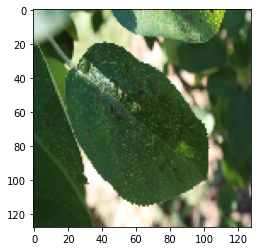

In [63]:
result = model.predict(x=test_imgs, steps=len(test_imgs), verbose=0)

In [64]:
result

array([[0.01823622, 0.09672154, 0.44223276, 0.01003068, 0.32478258,
        0.13149454],
       [0.38058087, 0.34475973, 0.17591156, 0.25686935, 0.11157941,
        0.31700033],
       [0.09200917, 0.24564484, 0.30927515, 0.06452481, 0.09589706,
        0.44624472]], dtype=float32)